# Test formation of quasicrystal by projection of high-dimentional unit cells

In [10]:
%matplotlib inline
from neurotools.nlab import *

In [11]:
# Generate a collection of paths in M dimensions
# Use the unit vector projection to identify the point location
# TODO: we need a better datastructure for detecting identical points
# I don't know how to do this theoretically unless they occupy
# The same location in the higher-dimensional lattice?

# Hypothesis: two projections are identical if and only if their unit vectors agree? 
# This may speed things up?

In [74]:
# Dimensionality
M = 11
# Scale 
K = 35
# Unit vectors; make explicit no using complex this time
phases = arange(M)*pi/M
units  = np.float64([cos(phases),sin(phases)])

In [75]:
units

array([[ 1.        ,  0.95949297,  0.84125353,  0.65486073,  0.41541501,
         0.14231484, -0.14231484, -0.41541501, -0.65486073, -0.84125353,
        -0.95949297],
       [ 0.        ,  0.28173256,  0.54064082,  0.75574957,  0.909632  ,
         0.98982144,  0.98982144,  0.909632  ,  0.75574957,  0.54064082,
         0.28173256]])

In [76]:
# Generate grid
S   = 10000
s   = np.linspace(-K,K,S).reshape((S,1))
z   = s[:,None]+1j*s[None,:]
x,y = z.real,z.imag
xy  = np.array([x,y]).squeeze()
xy  = xy.reshape(2,S*S)

In [77]:
# Lift 2D grid into unit basis (not uniquely constrained)
lifted = units.T.dot(xy)
# Quantize lifted points in higer dimensional unit basis
quanta = np.int32(np.round(lifted))
# Remove duplicate points
points = array(list(set(map(tuple,quanta.T)))).T
# Project back to 2D
shadow = units.dot(points)

In [70]:
from collections import defaultdict

def z2xy(z):
    '''
    Converts an array of complex numbers into two arrays
    representing real and imaginary parts, respectively.
    '''
    return real(z),imag(z)

def uniquerow(x):
    '''
    Removes duplicate rows from a 2D numpy array
    '''
    return array(list(set(map(tuple,x))))

def trianglesToEdges(triangles):
    '''
    Accepts Ntriangles x 3 array of triangle indeces, like the format
    returned by `scipy.spatial.Delaunay(...).simplices`. Returns a
    Nedges x 2 numpy array of unique edges in the triangulation
    '''
    tedges    = triangles[:,[0,1,1,2,2,0]].reshape((size(triangles),2))
    tedges    = uniquerow(sort(tedges,axis=1))
    return tedges

def edgesNearby(iz,microd):
    '''
    Returns a dictionary mapping from 
    indecies into point list iz 
    (2d locations passed as x+iy complex)
    to a list of nearby point indices
    
    Computed by thresholding delaunay triangulation
    '''
    points    = array([real(iz),imag(iz)])
    triangles = scipy.spatial.Delaunay(points.T).simplices
    tedges    = trianglesToEdges(triangles)
    edgelen   = ravel(abs(diff(iz[tedges],axis=1)))
    tedges    = tedges[edgelen<microd,:]
    
    #tedges = concatenate([tedges,tedges[:,[1,0]]])
    #coordsparse = scipy.sparse.coo_matrix((ones(tedges.shape[0]),(tedges[:,0],tedges[:,1])))
    #edgelist = scipy.sparse.csr_matrix(coordsparse)
    
    edgelist  = defaultdict(set)
    for i,z in enumerate(iz):
        edgelist[i] = tuple(ravel(tedges[(tedges==i)[:,[1,0]]]))   
    
    return edgelist

def coalesce(iz,edgelist):
    '''
    Joint connected components as defined in edgelist, and return the centroids
    taken as an average of all point locations in list iz 
    (2d locations passed as x+iy complex)
    '''
    components = {}
    for i in arange(len(iz)):
        components[i]=i
        for e in edgelist[i]:
        #for e in scipy.sparse.find(edgelist[i])[1]:
            if e in components:
                components[i]=components[e]
                break
    componentlist = defaultdict(set)
    for e,cid in components.items():
        componentlist[cid]|={e}
    component_ids = sorted(list(set(components.values())))
    centroids = array([mean(iz[array(list(componentlist[cid]))]) for cid in component_ids])
    return centroids

def plot_edges(iz,edges,**kwargs):
    '''
    Plots a set of edges given by 2d complex numbers and Nedges x 2 array of edge indices
    keword arguments are forwarded to matplotlib.plot
    '''
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()
    
def plot_triangles(iz,triangles,**kwargs):
    '''
    '''
    edges = trianglesToEdges(triangles)
    edgelist = ravel(np.concatenate([edges[:,:1]*NaN,iz[edges]],axis=1))
    plot(*z2xy(array(edgelist)),**kwargs)
    force_aspect()

(-25, 25)

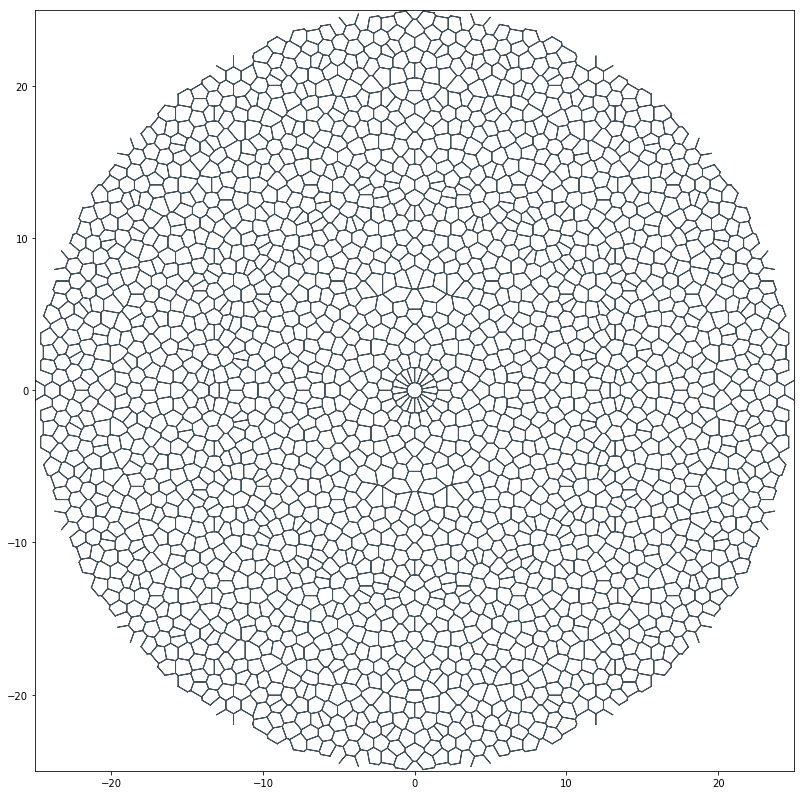

In [72]:
from scipy.spatial import Voronoi, voronoi_plot_2d
figure(figsize=(14,14))

vor = Voronoi(shadow.T,qhull_options="Qc")

v = vor.vertices
v = v[:,0]+1j*v[:,1]
v = array(v)
r = array(vor.regions)

ee = concatenate([array(list(zip(array(e)[arange(-1,len(e))],e))) for e in r])

v[abs(v)>K]=NaN

plot_edges(v,ee,color=BLACK,lw=1)

xlim(-K,K)
ylim(-K,K)

(-25, 25)

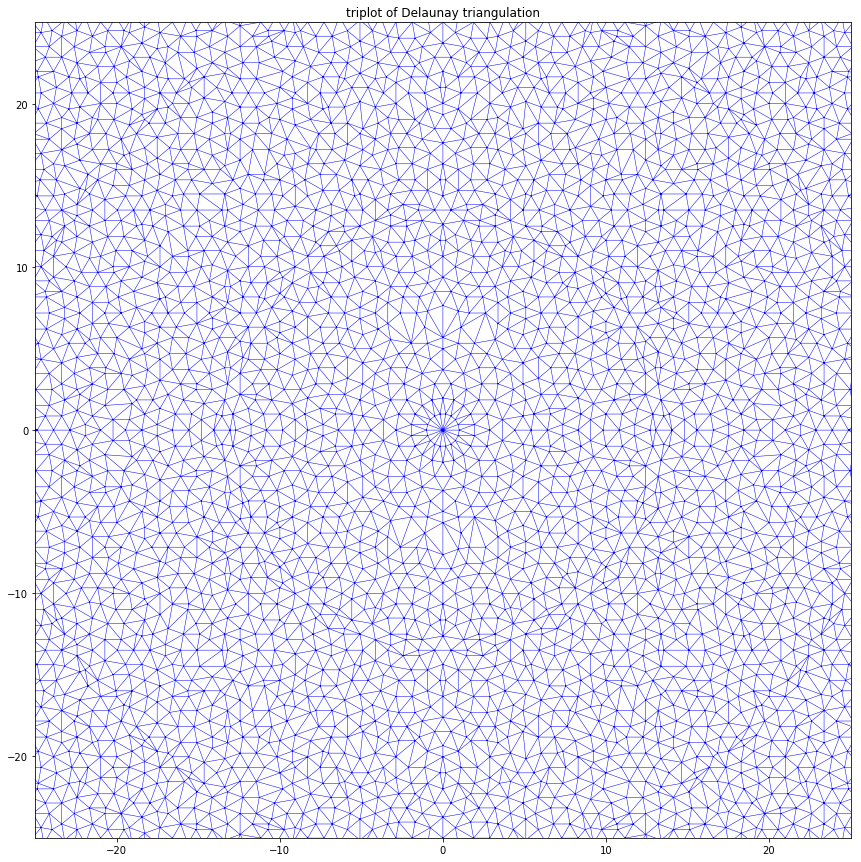

In [73]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import math

pp = shadow

# Create the Triangulation; no triangles so Delaunay triangulation created.
triang = tri.Triangulation(pp[0],pp[1])

# Plot the triangulation.
plt.figure(figsize=(15,15))
plt.gca().set_aspect('equal')
plt.triplot(triang, 'bo-', lw=0.5,markersize=0)
plt.title('triplot of Delaunay triangulation')


xlim(-K,K)
ylim(-K,K)